In [130]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap

In [136]:
def create_matrix(S, I, R, N):
    assert np.isclose(S + I + R, 1.0), "S + I + R should equal 1"

    total_population = N * N
    S_count = int(S * N**2)
    I_count = int(I * N**2)
    R_count = int(R * N**2)
    
    flat_array = np.zeros(int(N ** 2))
    flat_array[:S_count] = 0
    flat_array[S_count:S_count+I_count] = 1
    flat_array[S_count+I_count:] = 2

    np.random.shuffle(flat_array)

    matrix = flat_array.reshape(N, N)
    return matrix

In [143]:
matrix = create_matrix(0.99, 0.01, 0.0, 100)
print(matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Set initial conditions and constants
S = 0.99
I = 0.01
R = 0.0
N = 1000
beta = 0.33
gamma = 0.14
t = 365

matrix = create_matrix(S, I, R, N)

Simulating step 1...
Simulating step 2...
Simulating step 3...
Simulating step 4...
Simulating step 5...
Simulating step 6...
Simulating step 7...
Simulating step 8...
Simulating step 9...
Simulating step 10...
Simulating step 11...
Simulating step 12...
Simulating step 13...
Simulating step 14...
Simulating step 15...
Simulating step 16...
Simulating step 17...
Simulating step 18...
Simulating step 19...
Simulating step 20...
Simulating step 21...
Simulating step 22...
Simulating step 23...
Simulating step 24...
Simulating step 25...
Simulating step 26...
Simulating step 27...
Simulating step 28...
Simulating step 29...
Simulating step 30...
Simulating step 31...
Simulating step 32...
Simulating step 33...
Simulating step 34...
Simulating step 35...
Simulating step 36...
Simulating step 37...
Simulating step 38...
Simulating step 39...
Simulating step 40...
Simulating step 41...
Simulating step 42...
Simulating step 43...
Simulating step 44...
Simulating step 45...
Simulating step 46.

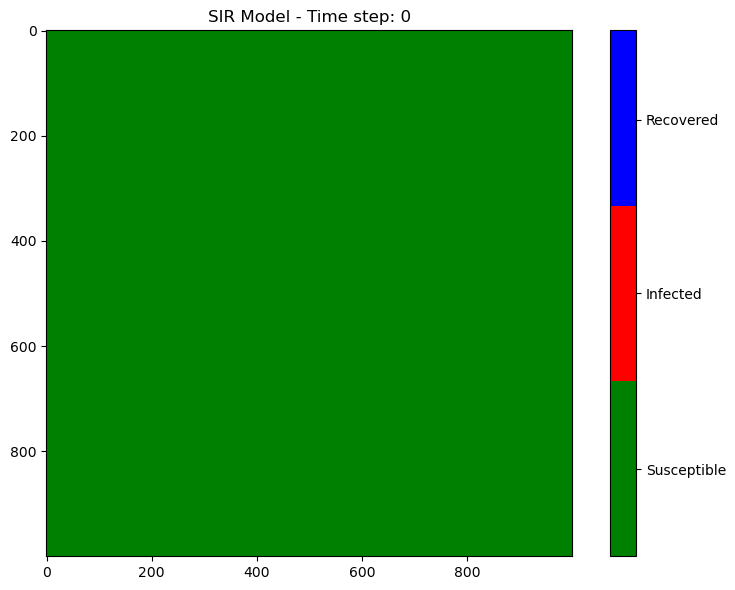

In [150]:
def check_neighbors(matrix, i, j):
    rows, cols = matrix.shape
    neighbors = []
    
    for x in [i-1, i, i+1]:
        for y in [j-1, j, j+1]:
            if (x != i or y != j) and (0 <= x < rows) and (0 <= y < cols):
                neighbors.append((x, y))
    return neighbors


def SIR_simulate_step(matrix, beta, gamma):
    rows, cols = matrix.shape
    new_matrix = matrix.copy() # matrix at t+1
    infection_sources = []

    for i in range(rows):
        for j in range(cols):
            if matrix[i][j] == 1:
                neighbors = check_neighbors(matrix, i, j)
                for x, y in neighbors:
                    if matrix[x][y] == 0 and np.random.uniform(0,1) < beta:
                        infection_sources.append((x, y))

    for x, y in infection_sources:
        new_matrix[x][y] = 1
    
    for i in range(rows):
        for j in range(cols):
            if matrix[i][j] == 1 and np.random.uniform(0, 1) < gamma:
                new_matrix[i][j] = 2
    return new_matrix


def SIR_simulation(matrix, beta, gamma, steps):
    simulations = []
    for t in range(steps):
        simulations.append(SIR_simulate_step(matrix, beta, gamma))
    return np.array(simulations)

def SIR_simulation(initial_matrix, beta, gamma, steps):
    simulations = [initial_matrix.copy()]
    current_matrix = initial_matrix.copy()
    
    for t in range(1, steps):
        print(f"Simulating step {t}...")
        current_matrix = SIR_simulate_step(current_matrix, beta, gamma)
        simulations.append(current_matrix.copy())
    
    return np.array(simulations)


def animate_SIR_simulation(simulation):
    print("Simulation shape:", simulation.shape)  # Should be (timesteps, rows, cols)
    
    # Define custom colormap for SIR states
    sir_colors = ['green', 'red', 'blue']  # S, I, R
    cmap = ListedColormap(sir_colors)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create initial plot
    im = ax.imshow(simulation[0], cmap=cmap, vmin=0, vmax=2)
    
    # Add colorbar with state labels
    cbar = plt.colorbar(im, ticks=[0.33, 1.0, 1.66])
    cbar.ax.set_yticklabels(['Susceptible', 'Infected', 'Recovered'])
    
    # Set title
    ax.set_title('SIR Model Simulation')
    
    def update(t):
        """Update the plot for each frame."""
        im.set_data(simulation[t])
        ax.set_title(f'SIR Model - Time step: {t}')
        return [im]
    
    # Create animation
    timesteps = simulation.shape[0]
    ani = FuncAnimation(fig, update, frames=timesteps, interval=100, blit=True)
    
    plt.tight_layout()
    plt.show()
    
    return ani

simulations = SIR_simulation(matrix, beta, gamma, t)

ani = animate_SIR_simulation(simulations)
ani.save("sir_sim.gif", writer='pillow', fps=2)


In [140]:
simulations

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0.

In [96]:
print(matrix)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 2. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 2. 2. 1. 0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 2. 1. 1. 0. 0.]
 [1. 1. 2. 2. 1. 1. 1. 1. 0. 2.]
 [0. 0. 2. 2. 1. 1. 1. 2. 2. 0.]
 [0. 1. 2. 2. 1. 2. 1. 2. 2. 2.]
 [1. 1. 2. 1. 2. 1. 2. 2. 2. 2.]
 [0. 2. 0. 1. 0. 0. 0. 1. 2. 2.]]
